In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
enable_wandb = True
if enable_wandb:
    import wandb
    wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: niklas-kemper. Use `wandb login --relogin` to force relogin


In [3]:
from torch_geometric.datasets import TUDataset

In [16]:
from substructures import get_rings, get_substructure_edge_index, get_node_counts
import torch
def pre_transform(graph):
    triangles = get_rings(graph.edge_index, max_k =3)
    squares = get_rings(graph.edge_index, min_k = 4, max_k = 4)
    substructures_edge_index = [get_substructure_edge_index(substructure) for substructure in [triangles, squares]]
    return graph.update({"x": torch.zeros((graph.num_nodes,1)), "substructures_edge_index": substructures_edge_index})

In [18]:
DATASET_NAME = "ENZYMES"
dataset = TUDataset(root=f'/tmp/{DATASET_NAME}_zero_features', name=DATASET_NAME, pre_transform = pre_transform, use_node_attr= True)

Processing...
Done!


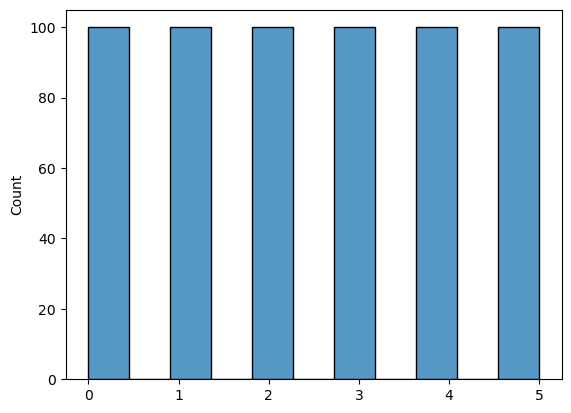

In [19]:
import seaborn as sns
from itertools import chain
sns.histplot(list(map(lambda x: int(x), list(chain(*[graph.y for graph in dataset])))))

In [20]:
from torch_geometric.loader import DataLoader

In [21]:
torch.manual_seed(0)
dataset = dataset.shuffle()
train_num = int(len(dataset) * 0.6)
val_num = int(len(dataset) * 0.2)
train_dataset = dataset[:train_num]
val_dataset = dataset[train_num:train_num + val_num]
test_dataset = dataset[train_num + val_num:]
train_loader = DataLoader(train_dataset, batch_size = 16)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [22]:
hyper = {"lr":0.01, 
         "weight_decay":5e-4, 
         "num_layers":3, 
         "batch_size": 16, 
         "hidden_channels": 16, 
         "substructures": ["triangles", "squares"], 
         "dataset": DATASET_NAME, 
         "target": "class", 
         "node_level_predictions": False, 
         "max_epochs": 50}

In [23]:
import simple_model_triangles
model = simple_model_triangles.SimpleSubstructureNeuralNetGraph(hidden_channels=hyper["hidden_channels"], out_channels=dataset.num_classes, in_channels = dataset.num_node_features, num_layers=hyper["num_layers"], num_substructures=2)

In [24]:
print(model)

SimpleSubstructureNeuralNetGraph(
  (layers): ModuleList(
    (0): SubstructureLayer(
      (message_neighbor): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=32, out_features=16, bias=True)
      ))
      (node2substructures): ModuleList(
        (0-1): 2 x Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=16, bias=True)
        )
      )
      (substructures2node): ModuleList(
        (0-1): 2 x Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=16, bias=True)
        )
      )
    )
    (1-2): 2 x SubstructureLayer(
      (message_neighbor): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_f

In [26]:
wandb.finish()

In [27]:
from trainer import GraphNetGraphClassification
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

wandb_logger = WandbLogger(project='enzyme dataset', name= "first test with triangle and square messages")
wandb_logger.experiment.config.update(hyper)
#wandb_logger.watch(model, log="all")

trainer = Trainer(max_epochs=hyper["max_epochs"], logger= wandb_logger, enable_progress_bar= False, log_every_n_steps=15)
model_lightning = GraphNetGraphClassification(model, lr = hyper["lr"], weight_decay = hyper["weight_decay"])

trainer.fit(model_lightning, train_dataloaders=train_loader, val_dataloaders= val_loader)
wandb.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type                             | Params
------------------------------------------------------------
0 | model  | SimpleSubstructureNeuralNetGraph | 16.5 K
1 | metric | CrossEntropyLoss                 | 0     
------------------------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
/Users/niklas/anaconda3/envs/substructureML/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/niklas/an

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_loss,▃▇▅▂▇▆▆▆▆▁▆█▇▇▆▁▇▆▆▆▆▁▆██▇▆▁▇▆▆▆▆▁▆██▇▆▅
val_acc,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
trainer/global_step,1149
training_loss,1.7911
val_acc,0.1875
val_loss,1.79421
